In [18]:
# Read from Datasets/kneeding.txt

import numpy as np
import matplotlib.pyplot as plt

# Read data ignoring the first row and first column, which is separated by ;
data = np.genfromtxt('Datasets/kneeding.txt', delimiter=';', skip_header=1, usecols=range(1, 91))

data = np.array([data[:, i] for i in range(len(data[0]))])

print(data.shape)

true_labels = np.zeros(90)
true_labels[0:50] = 0
true_labels[50:90] = 1

(90, 241)


Text(0, 0.5, 'Resistance')

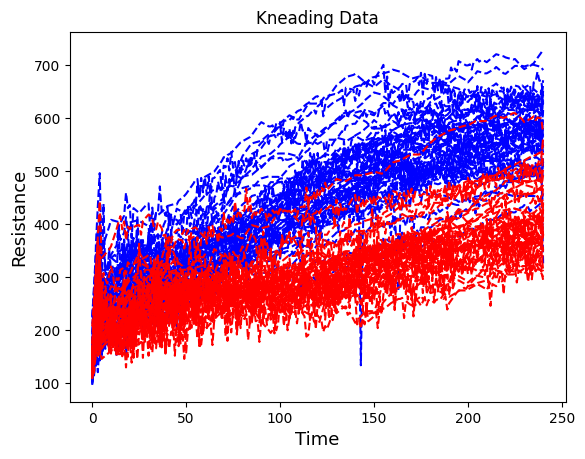

In [19]:
# Plot the data based on the labels
for i in range(90):
    if true_labels[i] == 0:
        plt.plot(data[i], '--b')
    else:
        plt.plot(data[i], '--r')
plt.title((
    'Kneading Data'))
plt.xlabel('Time', fontsize=13)
plt.ylabel('Resistance', fontsize=13)

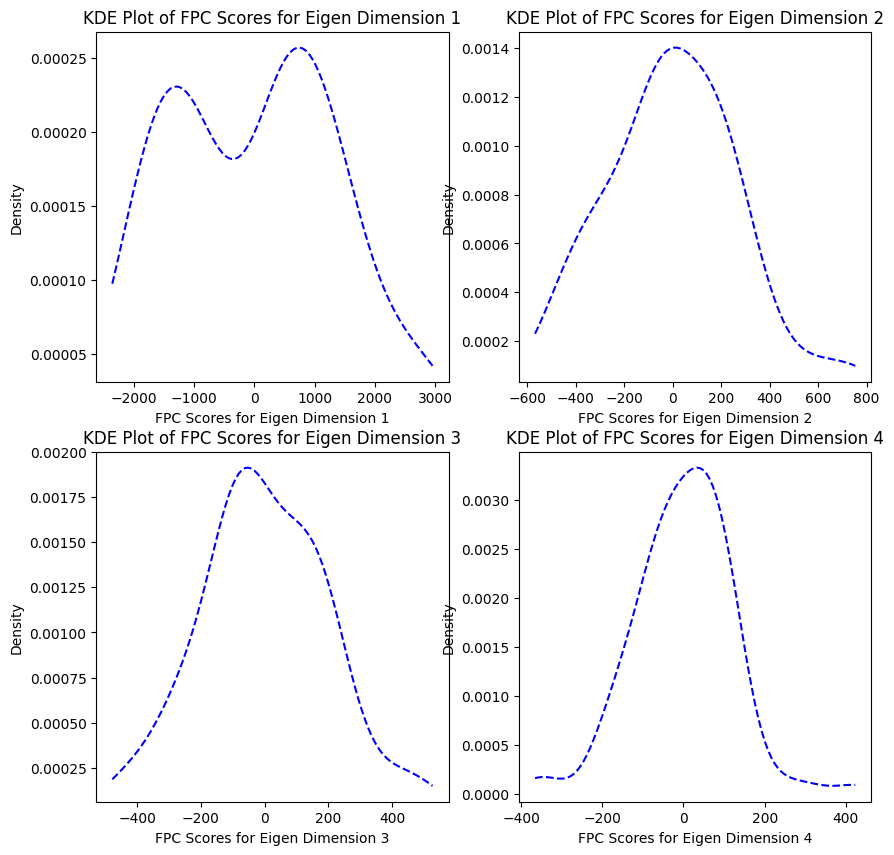

In [20]:
import scipy
from scipy import spatial, interpolate
from ensemble_clustering import functional_data_decomposition, functional_data_clustering
from fda_results import percentage_variation_ami_ari, plot_percentage_variation_ami_ari

data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 10, 250)

# For loop to plot a 2x2 set of scatter plots for the kernel density plots of the first four principal components
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
    # Kernel density plot for principal components[i], as a scatter plot
    # Determine the desnity of principal components[i]
    kde = scipy.stats.gaussian_kde(principal_componenets[:,i])
    # Create a grid of points
    x_grid = np.linspace(min(principal_componenets[:,i]), max(principal_componenets[:,i]), 100)
    # Evaluate the density on the grid
    density = kde(x_grid)
    # Plot the density
    ax[i//2, i%2].plot(x_grid, density, color='b', linestyle='--')
    ax[i//2, i%2].set_title('KDE Plot of FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_xlabel('FPC Scores for Eigen Dimension ' + str(i+1))
    ax[i//2, i%2].set_ylabel('Density')
plt.show()



Percentage of variation explained by each eigen dimensions:  [0.92270161 0.03645767 0.01997521 0.00724029 0.00428579 0.00257244
 0.00211241 0.00177421 0.00149447 0.00138589]


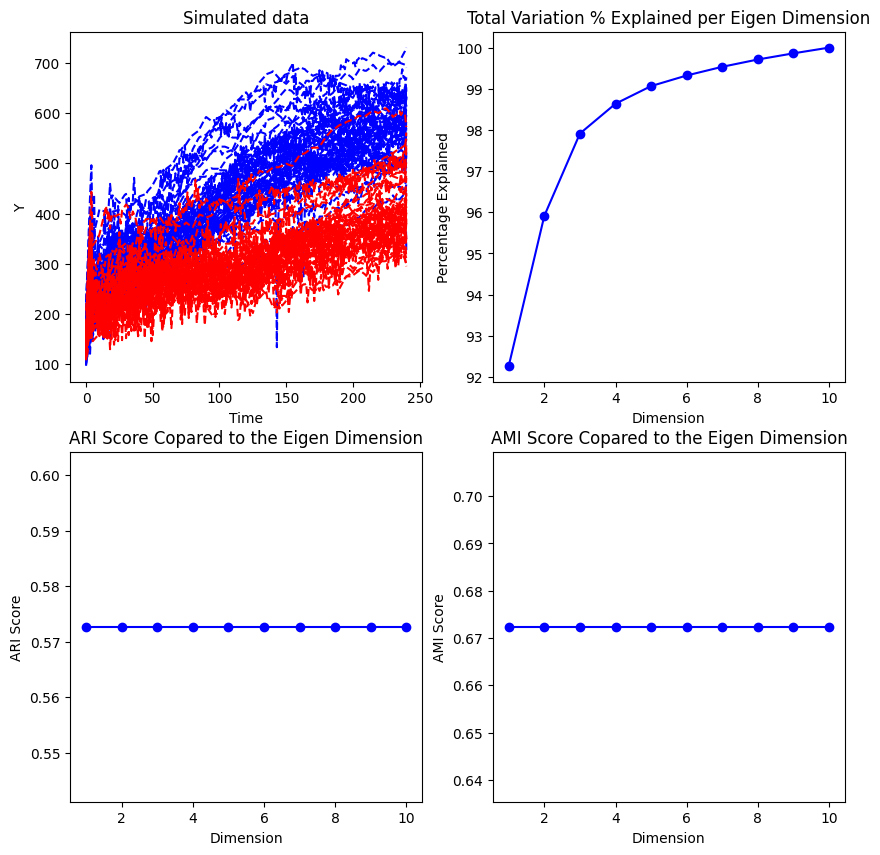

In [21]:
variance, ami, ari, v_range = percentage_variation_ami_ari(10, data, 150, true_labels, 2)
plot_percentage_variation_ami_ari(variance, ami, ari, v_range, true_labels, data)

In [22]:
# Determine the Eigen Dimension that explains 95% of the variance
for i in range(len(variance)):
    if sum(variance[:i]) >= 0.95:
        print('The Eigen Dimension that explains 95% of the variance is ' + str(i-1))
        V = i -1
        break

The Eigen Dimension that explains 95% of the variance is 1


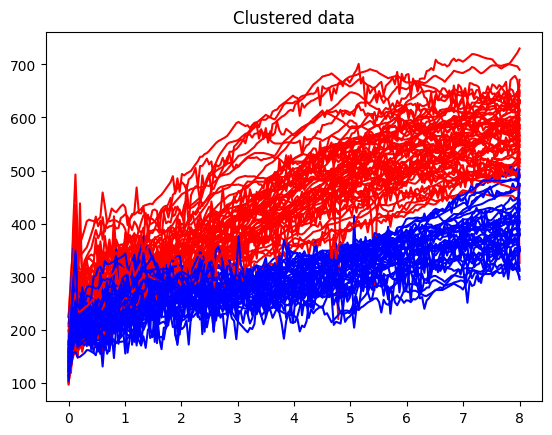

AMI score: 0.572689
ARI score: 0.672398


In [24]:
# Get data from the first function
data_smooth, mean, principal_componenets, eigen_functions = functional_data_decomposition (data, 2, 200)

# Get data from the second function
membership_matrices, labels = functional_data_clustering (principal_componenets, 2)

# Plot the curves with their labels
t = np.expand_dims(np.linspace(0, 8, len(data_smooth[0])), 1)
for i in range(len(data_smooth)):
    if labels[i] == 0:
        plt.plot(t, data_smooth[i], '-b')
    else:
        plt.plot(t, data_smooth[i], '-r')
plt.title('Clustered data')
plt.show()

from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("AMI score: %f" % adjusted_mutual_info_score(true_labels, labels))
print("ARI score: %f" % adjusted_rand_score(true_labels, labels))

In [25]:
from FDApy.clustering.fcubt import Node, FCUBT
from FDApy.representation.functional_data import DenseFunctionalData

# Ignore the warning
import warnings
warnings.filterwarnings("ignore")

# Make t a dict
t = np.expand_dims(np.linspace(0, 20, len(data[0])), 1)
t = {'input_dim_0': t}
# Change t from (100, 1) to (100,)
t = {k: v.squeeze() for k, v in t.items()}

fcubt_data = DenseFunctionalData(t, data)
# Build the tree
root_node = Node(fcubt_data, is_root=True)
fcubt = FCUBT(root_node=root_node)

# Growing
fcubt.grow(n_components=0.95, min_size=10)

# Joining
fcubt.join(n_components=0.95)

# Get the ARI
print("ARI score for FCUBT: %f" % adjusted_rand_score(true_labels, fcubt.labels_join))
# Get the AMI
print("AMI score for FCUBT: %f" % adjusted_mutual_info_score(true_labels, fcubt.labels_join))

ARI score for FCUBT: 0.635946
AMI score for FCUBT: 0.528698


In [35]:
# Store the data in DataStore.csv
np.savetxt('Data/DataStore.csv', data, delimiter=',')
np.savetxt('Data/LabelStore.csv', true_labels, delimiter=',')

In [27]:
# To simulate funHDDC, run run the R file funHDDC.R

# Read Labels from PredictedLabels.csv, ignoring the header and the first column
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=1)
print("ARI score for funHDDC: %f" % adjusted_rand_score(true_labels, predicted_labels))
print("AMI score for funHDDC: %f" % adjusted_mutual_info_score(true_labels, predicted_labels))

ARI score for funHDDC: 0.787766
AMI score for funHDDC: 0.687574


In [40]:
# To simulate funFEM, run run the R file funFEM.R

# Read labels from PredictedLabels.csv, ignoring the header and the first column and getting the first four columns
predicted_labels = np.genfromtxt('Data/PredictedLabelsStore.csv', delimiter=',', skip_header=1, usecols=range(1, 3))
#   Format the labels
labels = np.zeros(len(predicted_labels))
for i in range(len(predicted_labels)):
    labels[i] = np.argmax(predicted_labels[i])
print("ARI score for funFEM: %f" % adjusted_rand_score(labels, true_labels))
print("AMI score for funFEM: %f" % adjusted_mutual_info_score(labels, true_labels))

ARI score for funFEM: 0.133004
AMI score for funFEM: 0.092447
